In [24]:
import pandas as pd
import numpy as np
import xarray as xr
import math
import matplotlib.pyplot as plt

data = xr.open_dataset("data/delhi_cpcb_2022.nc")
# data = xr.open_dataset("delhi_cpcb_2022.nc")
data

<xarray.Dataset>
Dimensions:    (station: 40, time: 8783)
Coordinates:
  * station    (station) object 'Alipur, Delhi - DPCC' ... 'Wazirpur, Delhi -...
  * time       (time) datetime64[ns] 2022-01-01T00:30:00 ... 2023-01-01T22:23:30
    latitude   (station) float64 ...
    longitude  (station) float64 ...
Data variables: (12/21)
    From Date  (station, time) datetime64[ns] ...
    To Date    (station, time) datetime64[ns] ...
    PM2.5      (station, time) float64 ...
    PM10       (station, time) float64 ...
    NO         (station, time) float64 ...
    NO2        (station, time) float64 ...
    ...         ...
    WD         (station, time) float64 ...
    SR         (station, time) float64 ...
    BP         (station, time) float64 ...
    AT         (station, time) float64 ...
    RF         (station, time) float64 ...
    TOT-RF     (station, time) float64 ...

In [25]:
lat_list = [28.815329,28.647622,28.695381,28.4706914,28.7762,28.7256504,28.5512005,28.656756,28.7500499,28.498571,28.5710274,28.655935,28.5627763,28.6811736,28.628624,28.73282,28.58028,28.588333,28.5918245,28.611281,28.636429,28.684678,28.60909,28.570173,28.822836,28.56789,28.6573814,28.530785,28.623763,28.674045,28.639645,28.639645,28.563262,28.732528,28.6514781,28.5504249,28.710508,28.531346,28.672342,28.699793]

In [26]:
df = data.to_dataframe().reset_index()
df = df[df["time"]=="2022-03-01 00:30:00"]
df = df.dropna(subset=["PM2.5"])
df = df.rename(columns={"RH": "relative_humidity", "WS": "wind_speed", "WD": "wind_direction", "SR": "solar_radiation", "BP": "pressure", "AT": "temperature", "RF": "rain_fall", "TOT-RF": "total_rainfall"})

In [27]:
df.head()

,station,time,From Date,To Date,PM2.5,PM10,NO,NO2,NOx,NH3,...,relative_humidity,wind_speed,wind_direction,solar_radiation,pressure,temperature,rain_fall,total_rainfall,latitude,longitude
1416,"Alipur, Delhi - DPCC",2022-03-01 00:30:00,2022-03-01,2022-03-01 01:00:00,99.00,252.00,14.55,48.38,37.57,3.80,...,77.40,NaN,244.70,4.60,993.62,11.85,0.0,0.0,28.815329,77.153010
10199,"Anand Vihar, Delhi - DPCC",2022-03-01 00:30:00,2022-03-01,2022-03-01 01:00:00,71.50,251.75,36.90,49.73,56.52,17.53,...,70.88,0.30,254.25,9.03,973.77,15.32,NaN,0.0,28.647622,77.315809
18982,"Ashok Vihar, Delhi - DPCC",2022-03-01 00:30:00,2022-03-01,2022-03-01 01:00:00,91.00,163.50,12.48,89.10,57.55,46.17,...,69.52,0.33,189.92,5.47,987.40,14.10,0.0,0.0,28.695381,77.181665
27765,"Aya Nagar, Delhi - IMD",2022-03-01 00:30:00,2022-03-01,2022-03-01 01:00:00,70.55,149.83,27.16,28.05,55.19,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,28.470691,77.109936
36548,"Bawana, Delhi - DPCC",2022-03-01 00:30:00,2022-03-01,2022-03-01 01:00:00,156.00,282.75,4.65,22.20,26.77,40.20,...,78.88,0.73,23.40,5.67,993.40,13.02,0.0,0.0,28.776200,77.051074


In [28]:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
df['station'] = le.fit_transform(df['station'])

In [29]:
station = {}
lat = []
long = []
for i in df.station.unique():
    lat_i = df[df['station'] == i]['latitude'].item()
    long_i = df[df['station'] == i]['longitude'].item()
    pm_i = df[df['station'] == i]['PM2.5'].item()
    
    station[i] = [lat_i, long_i, pm_i]
    long.append(long_i)
    lat.append(lat_i)

In [30]:
import math

def get_distance(lat1, lon1, lat2, lon2):
    # Calculate the distance between the coordinates using the Haversine formula
    radius = 6371  # Earth's radius in kilometers
    dlat = math.radians(lat2 - lat1)
    dlon = math.radians(lon2 - lon1)
    a = math.sin(dlat/2) * math.sin(dlat/2) + math.cos(math.radians(lat1)) * math.cos(math.radians(lat2)) * math.sin(dlon/2) * math.sin(dlon/2)
    c = 2 * math.atan2(math.sqrt(a), math.sqrt(1-a))
    distance = radius * c
    return distance

distances = []
for i in station.keys():
    temp = []
    for j in station.keys():
        if i==j:
            continue
        else:
            temp.append([get_distance(station[i][0], station[i][1], station[j][0], station[j][1]), j])
    distances.append(temp)


In [31]:
for i in range(len(distances)):
    distances[i].sort()

In [32]:
import networkx as nx

no_of_neighbours = 9

G = nx.Graph()

for i in range(len(distances)):
    G.add_node(i, latitude = station[i][0], longitude = station[i][1], pm = station[i][2])
    
    for j in range(no_of_neighbours):
        s = distances[i][j][1]
        G.add_node(s, latitude = station[s][0], longitude = station[s][1], pm = station[s][2])
        G.add_edge(i, s)


In [33]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch_geometric.data import Data, Dataset

node_features = [(G.nodes[node]['latitude'], G.nodes[node]['longitude']) for node in G.nodes]
edge_index = torch.tensor(list(G.edges)).t().contiguous()
y = torch.tensor([G.nodes[node]['pm'] for node in G.nodes], dtype=torch.float).view(-1, 1)
sorted_nodes = sorted(G.nodes(), key=lambda node: G.nodes[node]['latitude'])

# Divide train and test masks based on the sorted latitudes
train_mask = torch.zeros(y.size(0), dtype=torch.bool)
test_mask = torch.zeros(y.size(0), dtype=torch.bool)

for i, node in enumerate(G.nodes):
    lat = G.nodes[node]['latitude']
    if lat in lat_list[:25]:
        train_mask[i] = True
    else:
        test_mask[i] = True


data1 = Data(x=torch.tensor(node_features, dtype=torch.float), edge_index=edge_index, y=y,train_mask=train_mask, test_mask=test_mask)

In [34]:
from torch_geometric.nn import GCNConv, GATConv

class RegressionModel(nn.Module):
    def __init__(self, input_dim):
        super(RegressionModel, self).__init__()
        self.conv1 = GCNConv(input_dim, 16)
        self.conv2 = GCNConv(16, 10)
        self.linear1 = nn.Linear(10, 10)
        self.linear2 = nn.Linear(10, 1)

    def forward(self, x, edge_index):
        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = self.conv2(x, edge_index)
        x = F.relu(x)
        x = self.linear1(x)
        x = F.relu(x)
        x = self.linear2(x)
        return x


In [35]:
import random
seed = 42
random.seed(seed)
torch.manual_seed(seed)


device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model1 = RegressionModel(input_dim=2).to(device)
optimizer = torch.optim.Adam(model1.parameters(), lr=0.01)
criterion = nn.MSELoss()

In [36]:
train_rmse_list1 = []
test_rmse_list1 = []

from tqdm import tqdm

#Training Loop for G1
for epoch in tqdm(range(2500)):
    optimizer.zero_grad()
    out = model1(data1.x.to(device), data1.edge_index.to(device))
    loss = criterion(out[data1.train_mask].squeeze(), data1.y[data1.train_mask].squeeze())
    loss.backward()
    optimizer.step()
    if(epoch%100==0):
        model1.eval()
        with torch.no_grad():
            out = model1(data1.x.to(device), data1.edge_index.to(device))  # Predicted PM values
            train_rmse = torch.sqrt(torch.mean((out[data1.train_mask].squeeze() - data1.y[data1.train_mask].squeeze())**2))
            test_rmse = torch.sqrt(torch.mean((out[data1.test_mask].squeeze() - data1.y[data1.test_mask].squeeze())**2))
            train_rmse_list1.append(train_rmse.item())
            test_rmse_list1.append(test_rmse.item())
        model1.train()

100%|██████████| 2500/2500 [00:01<00:00, 1259.60it/s]


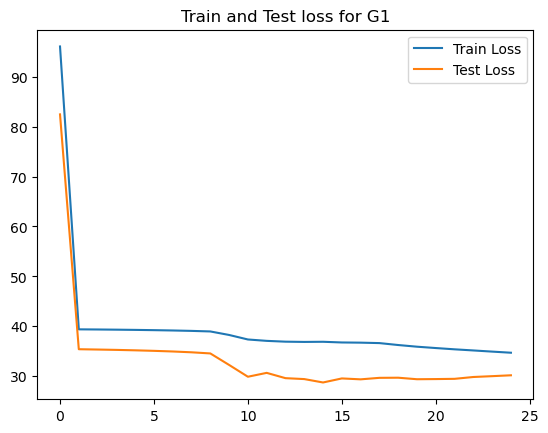

In [37]:
# Assuming you have train_loss_list and test_loss_list as lists containing the respective losses

# Plotting train loss
plt.plot(range(len(train_rmse_list1)), train_rmse_list1, label='Train Loss')

# Plotting test loss
plt.plot(range(len(test_rmse_list1)), test_rmse_list1, label='Test Loss')
plt.title("Train and Test loss for G1")
plt.legend()
plt.show()

In [38]:
model1.eval()
with torch.no_grad():
    out = model1(data1.x.to(device), data1.edge_index.to(device))  # Predicted PM values
    train_rmse = torch.sqrt(torch.mean((out[data1.train_mask].squeeze() - data1.y[data1.train_mask].squeeze())**2))
    test_rmse = torch.sqrt(torch.mean((out[data1.test_mask].squeeze() - data1.y[data1.test_mask].squeeze())**2))
    print("G1")
    print(f"GNN train rmse:{train_rmse}")
    print(f"GNN test rmse: {test_rmse}")

G1
GNN train rmse:34.45634078979492
GNN test rmse: 30.85107421875


In [39]:
latitudes = np.array(df['latitude'])
longitudes = np.array(df['longitude'])
g_lat = np.linspace(latitudes.min()-0.1, latitudes.max()+0.1, 30)
g_long = np.linspace(longitudes.min()-0.1, longitudes.max()+0.1, 30)
lat_grid, lon_grid = np.meshgrid(g_lat, g_long)

train = df[['latitude', 'longitude', 'PM2.5']]
test_stats = [i for i in range(len(lon_grid.flatten()))]
test = pd.DataFrame({'longitude':lon_grid.flatten(),
                     'latitude':lat_grid.flatten(),
                     'station':test_stats})

In [40]:
station = {}
lat = []
long = []
for i in test.station.unique():
    lat_i = test[test['station'] == i]['latitude'].item()
    long_i = test[test['station'] == i]['longitude'].item()
    
    station[i] = [lat_i, long_i]
    long.append(long_i)
    lat.append(lat_i)

In [41]:
import math

def get_distance(lat1, lon1, lat2, lon2):
    # Calculate the distance between the coordinates using the Haversine formula
    radius = 6371  # Earth's radius in kilometers
    dlat = math.radians(lat2 - lat1)
    dlon = math.radians(lon2 - lon1)
    a = math.sin(dlat/2) * math.sin(dlat/2) + math.cos(math.radians(lat1)) * math.cos(math.radians(lat2)) * math.sin(dlon/2) * math.sin(dlon/2)
    c = 2 * math.atan2(math.sqrt(a), math.sqrt(1-a))
    distance = radius * c
    return distance

distances = []
for i in station.keys():
    temp = []
    for j in station.keys():
        if i==j:
            continue
        else:
            temp.append([get_distance(station[i][0], station[i][1], station[j][0], station[j][1]), j])
    distances.append(temp)

for i in range(len(distances)):
    distances[i].sort()

In [42]:
import networkx as nx

Gh = nx.Graph()

for i in range(len(distances)):
    Gh.add_node(i, latitude = station[i][0], longitude = station[i][1])
    
    for j in range(no_of_neighbours):
        s = distances[i][j][1]
        Gh.add_node(s, latitude = station[s][0], longitude = station[s][1])
        Gh.add_edge(i, s)

In [43]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch_geometric.data import Data, Dataset

#Gh
node_features = [(Gh.nodes[node]['latitude'], Gh.nodes[node]['longitude']) for node in Gh.nodes]
edge_index = torch.tensor(list(Gh.edges)).t().contiguous()
# y = torch.tensor([G1.nodes[node]['pm'] for node in G1.nodes], dtype=torch.float).view(-1, 1)

data_h = Data(x=torch.tensor(node_features, dtype=torch.float), edge_index=edge_index)

In [44]:
out = model1(data_h.x.to(device), data_h.edge_index.to(device))
test['PM2.5'] = out.detach().numpy()

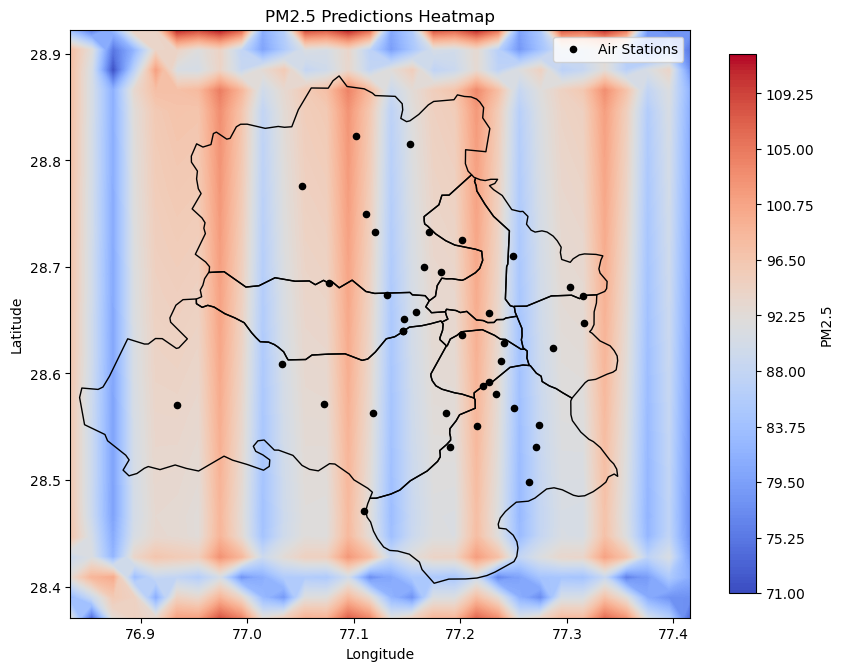

In [45]:
import heatmap
heatmap.plot_heatmap(lon = np.array(test['longitude']), lat = np.array(test['latitude']), values = test['PM2.5'].values)

In [46]:
len(test['PM2.5'])

900